# Attempt 1 at Convolutional VAE for CIFAR10
The goal of this project is to learn how the training of Conv VAE's scales with a dataset complexity increase.

This notebook contains my initial implementation of a covolutional variational autoencoder on the CIFAR10 Dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

This implementation was not very successful, however it provided some key insights for improving the model in the next attempt.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

# Load CIFAR10

Here the CFAR10 is loaded, transformations are applied, and the data is wrapped in a dataloader. The images are normalized to mean 0.5 and std 0.5 for each channel. They are wrapped in dataloaders for training.

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #(mean_each_channel, std_each_channel)

# Download and load the training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Below is a plot of 20 imahes from ther CIFAR10 dataset. The images are 32x32x3, where the 3 represents the RGB channels.

torch.Size([64, 3, 32, 32])


Text(0.5, 0.98, 'CIFAR10 Dataset')

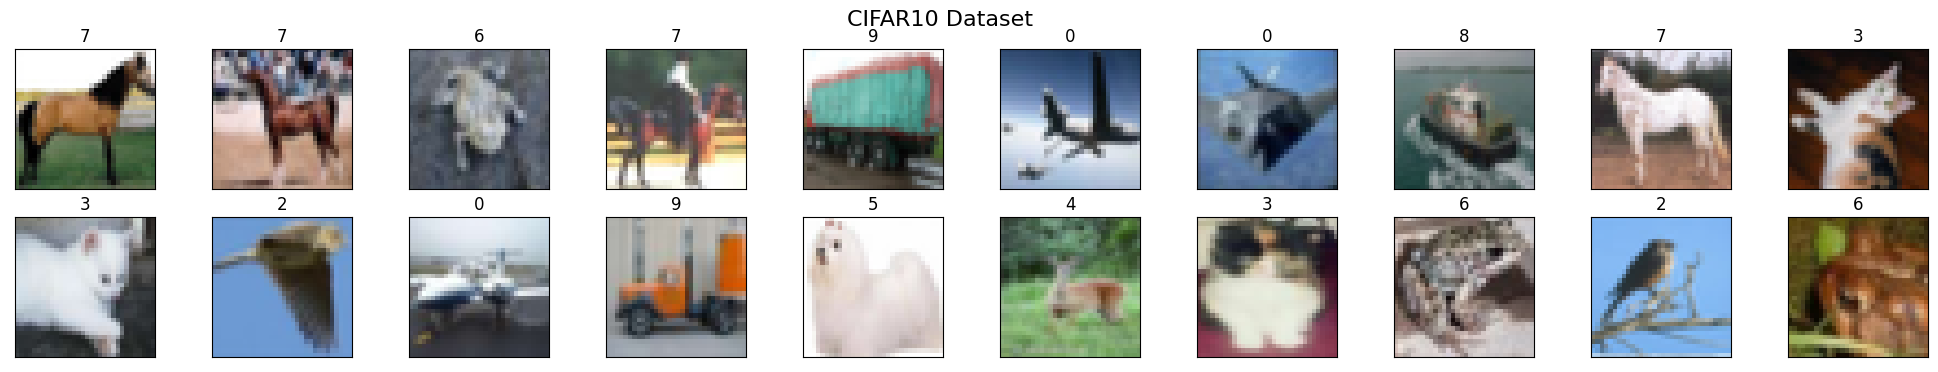

In [4]:
def denormalize(image): # Denormalize the input image before displaying
    image = image * 0.5 + 0.5
    return image.clamp(0, 1)

# Get one batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
print(images.shape)  # Should print torch.Size([64, 3, 32, 32]) for CIFAR10 dataset

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(denormalize(images[idx]), (1, 2, 0)))  # Denormalize before plotting
    ax.set_title(str(labels[idx].item()))
fig.suptitle('CIFAR10 Dataset', fontsize=16) 

# Model

Here I define the VAE model. It's architecture is described below.

The encoder takes as input a [batch, 3, 32, 32] image tensor and runs it through three convolutional blocks. Each convolutional block contains 3 Conv2d layers. Each of them are followed by ReLU activation then BatchNorm. BatchNorm is placed after ReLU activation to stabilize the inputs into the next conv layer. BatchNorm before activation was also tested but resulted in failure to converge. The encoder and the decoder are symmetrical opposites.

Between the encoder and the decoder, two linear layers compute the flattened the mean and logvar of each dimmension of the flattned output of the encoder. They are used in the reparamatrization trick to sample from the gaussian distribution they define. To which this distribution is fed into the decoder, which passes it through a linear and unflatten layer to return it to the output size of the encoder before flattening began. The decoder architecture after this performs the opposite operations of the encoder and returns an image of the original input size.

In [11]:
class VAE(nn.Module):
    def __init__(self, input_channels, flattned_output_dim, latent_distr_dim, unflattened_size):
        super(VAE, self).__init__()
        self.input_dim = input_channels
        self.flattned_output_dim = flattned_output_dim
        self.latent_dim = latent_distr_dim
        self.unflattened_size = unflattened_size

        # Encoder
        self.encoder = nn.Sequential(
            #conv block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #conv block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten())
            

        # Separate layers for computing mean and log variance of each dim in the Latent space
        # Note depending on how the latent_distr_dim is defined when instantiating the model,
        # the dimmension may be lower than that of the flattened_output_dim
        self.mu = nn.Linear(flattned_output_dim, latent_distr_dim)
        self.logvar = nn.Linear(flattned_output_dim, latent_distr_dim)

        # Symetrical Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_distr_dim, flattned_output_dim),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=unflattened_size),

            #conv block 1
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 2
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 3
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Upsample(scale_factor=2, mode='nearest'),

            #conv block 4
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),

            nn.Sigmoid())
   
    def reparametrize(self, mu, logvar):
        '''
        With the mean and the std of the encoded input, transform a sample of the standard 
        normal distribution N(0, 1) to the distribution of the encoded input by z = mu + std*eps
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) #encode the input, return its flattened form
        mu, logvar = self.mu(encoded), self.logvar(encoded) #get the mean and the log of the variance
        reparametrized = self.reparametrize(mu, logvar) #reparametrize
        decoded = self.decoder(reparametrized) #decode the reparametrized latent
        return decoded, mu, logvar
    
    def loss(self, input, decoded, mu, logvar):
        '''
        The KL divergence loss measures the difference between the standard
        normal distribution and the distribution defined by the encoder 
        output's mean and variance. The reconstruction loss measures the
        difference between the decoded output and the input.
        '''
        recon_loss = F.binary_cross_entropy(decoded, input, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return [(recon_loss + kl_divergence), recon_loss, kl_divergence] #total loss, recon, kl_div

# Shapes within the Forward Pass
Below are shown the shapes of the image data as it is passed through the network.

In [12]:
images, labels = dataiter.__next__()
print(f'Input Shape: {images.shape}\n')

vae = VAE(input_channels=3, flattned_output_dim=2048, latent_distr_dim=1024, unflattened_size=(128, 4, 4)) 

# Load state dictionary from the saved model and map the storages to CPU
state_dict = torch.load('vae_1_state_dict (1).pth', map_location=torch.device('cpu'))

# Load the state dictionary into your model
vae.load_state_dict(state_dict, strict=False)

encoded = vae.encoder(images)   #(batch, [output_channels * 2 (32/num max poolings) ]) --> (64, 512)
print(f"Encoded Shape: {encoded.shape}\n") 

mu, logvar = vae.mu(encoded), vae.logvar(encoded)
print(f"Mean and Log Variance Shapes: {mu.shape}, {logvar.shape}\n")

reparametrized = vae.reparametrize(mu, logvar)
print(f"Reparametrized Shape: {reparametrized.shape}\n")

decoded = vae.decoder(reparametrized)
print(f"Decoded Shape: {decoded.shape}\n")

Input Shape: torch.Size([64, 3, 32, 32])

Encoded Shape: torch.Size([64, 2048])

Mean and Log Variance Shapes: torch.Size([64, 1024]), torch.Size([64, 1024])

Reparametrized Shape: torch.Size([64, 1024])

Decoded Shape: torch.Size([64, 3, 32, 32])



# Model Parameters

In [13]:
num_params = sum(p.numel() for p in vae.parameters())
print(f'VAE has {num_params} parameters')

VAE has 6964171 parameters


# Training Loop

Notes on the training loop:

When the vae was initialized, 4 class variables are specified. The first, input_channels, refers to the 3 rbg channels of the input image. flattened_output_dim refers to the output shape of the encoder after it has been flattened. latent distr_dim refers to the number of samples in the in the latent distribution. unflattened_size refers to the size of the flattened_output_dim before it was flattened. 

I've added L2 Regularization to counteract any overfitting that may arise from the high number of 6,963,901 parameters. L2 regularization is a penalty added to the loss function to disincentivize the model weights from growing too large during training. Mathematically, this is (1/2) * lambda * ||w||^2 where lambda is the weight decay parameter specified in the optimizer. ||w|| is the vector magnitude of the weights

Early Stopping with a patience is used to determine the number of epochs. 1000 epochs is an arbitrarily high choice. The early stopping mechanism starts by switching the model state to eval mode. Then without gradient computation, it computes a sum of the loss over the entire test_set which is then averaged over the length of the test set. The total loss, reconstruction loss, and kl divergence loss are printed, the model is then returned to train mode. A check is made whether the total loss has exceeded the patience before the next epoch begins.




In [8]:
def training(model, optimizer, epochs=1000, early_stopping_patience = 5, device=device):
    #initialize early stopping params
    patience, counter, min_loss = early_stopping_patience, 0, np.Inf
    
    #initialize learning curve data
    learning_curves = []
    
    #Training Loop
    for epoch in range(epochs):
        for i, (data, _) in enumerate(trainloader): 
            inputs = data.to(device)
            decoded, mu, logvar = vae(inputs)
            loss = vae.loss(inputs, decoded, mu, logvar)[0]  #loss returns list [total_loss, recon_loss, kl_divergence]

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate
            optimizer.step()  # Update the weights


        #get model prog and early stopping in eval mode
        vae.eval() #set eval mode
        with torch.no_grad():
            total_loss, recon_loss, kl_divergence = 0, 0, 0 #initialize loss calculation
            for i, (data, _) in enumerate(testloader): #run through test set
                inputs = data.to(device)
                decoded, mu, logvar = vae(inputs)
                loss = vae.loss(inputs, decoded, mu, logvar) #loss returns list [total_loss, recon_loss, kl_divergence]  

                total_loss += loss[0].item() #.item converts torch tensor to python number
                recon_loss += loss[1].item()
                kl_divergence += loss[2].item() #add respective losses to each sum

            total_loss /= len(testloader) #average sums across batches
            recon_loss /= len(testloader) 
            kl_divergence /= len(testloader) 
        print(f'Epoch: {epoch}, Total loss: {total_loss:.4f} - - - Reconstruction Loss: {recon_loss:.4f} - - - KL Divergence {kl_divergence:.4f}')
        learning_curves.append([total_loss, recon_loss, kl_divergence])
        
        vae.train() #set model to train mode 

        #early stopping
        if total_loss < min_loss:
            min_loss = total_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch: {epoch} \nFinal Loss was {total_loss:.4f}')
                break
                
    return learning_curves
                

#  Run Training
During this run of training, the reconstruction loss showed convergence however the kl_divergence climbed as the epochs grew. This means that the way the model is being trained right now is biased towards the autoencoder aspect of the VAE. The kl divergence disincentive is not strong enough to result in meaningful generative capabilities.

I have removed the training printout for concision, but will save it to a text file.

In [ ]:
#initialize parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Data and Model will be loaded to: {device} \n')

vae = VAE(input_channels=3, flattned_output_dim=2048, latent_distr_dim=1024, unflattened_size=(128, 4, 4)) 
vae = vae.to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001, weight_decay=0.1) #added L2 regularization to minimize overfitting

epochs = 1000



learning_curves = training(model=vae, optimizer=optimizer, epochs=1000, early_stopping_patience=5, device=device)

In [76]:
# Save
torch.save(vae.state_dict(), 'vae_1_state_dict.pth')

# Learning Curves

In [70]:
def plot_learning_curves(learning_curves):
    epochs = range(1, len(learning_curves) + 1)
    total_loss = [curve[0] for curve in learning_curves]
    reconstruction_loss = [curve[1] for curve in learning_curves]
    kl_divergence_loss = [curve[2] for curve in learning_curves]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, total_loss, label='Total Loss')
    plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
    plt.plot(epochs, kl_divergence_loss, label='KL Divergence Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

The learning curves illustrate that the model is reaching a convergence on the reconstruction loss. However the kl_divergence is increasing. 

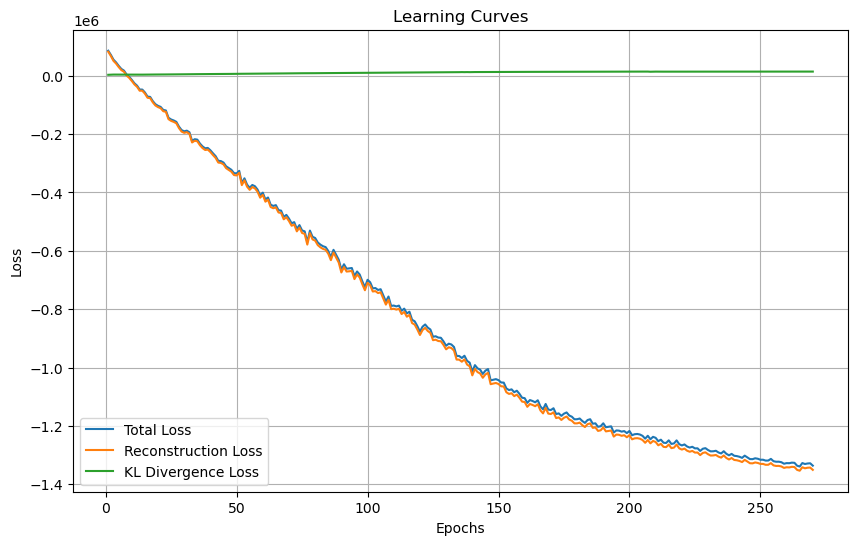

In [71]:
plot_learning_curves(learning_curves)

# Plot of Autoencoder Stages

Below is a plot of the forward pass of the autoencoder. Careful reading of the tea leaves reveals that the decoded image does contain many of the spatial aspects of the input. However, the color is off and the image is extremely blurry. This is a poor performance despite the convergence of the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


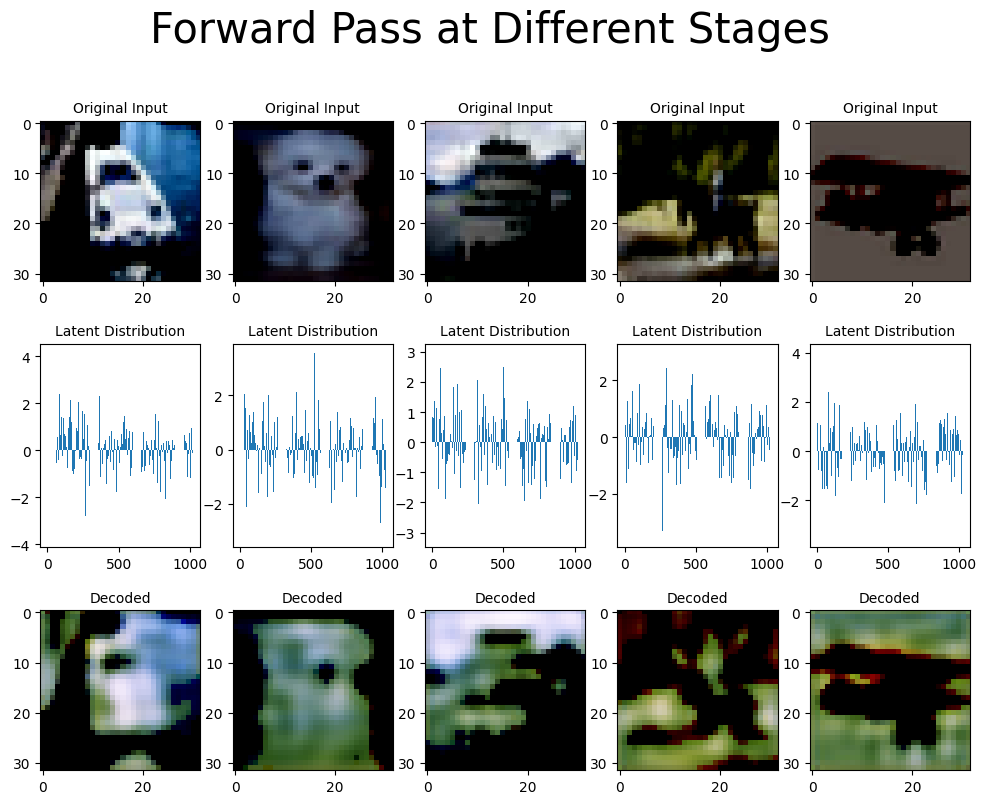

In [20]:
def plot_autoencoded():
    dataiter = iter(testloader)
    images, labels = dataiter.__next__()
    inputs = images
    decoded, mu, logvar = vae(inputs)

    fig, ax = plt.subplots(3, 5, figsize=(12, 9))
    fig.suptitle("Forward Pass at Different Stages", fontsize=30)

    for i in range(5):
        #original image
        image = inputs[i].cpu().view(3, 32, 32).permute(1, 2, 0).detach().numpy()
        ax[0][i].imshow(image)
        #set title of each subplot
        ax[0][i].set_title("Original Input", fontsize=10)

        #latent distribution bar plot
        distribution = vae.reparametrize(mu[i].detach(), logvar[i].detach()).cpu().numpy()
        ax[1][i].bar(np.arange(1024), distribution)
        ax[1][i].set_title("Latent Distribution", fontsize=10)  

        #decoded image
        image = decoded[i].cpu().view(3, 32, 32).permute(1, 2, 0).detach().numpy()
        ax[2][i].imshow(image)
        ax[2][i].set_title("Decoded", fontsize=10)
        
plot_autoencoded()

# Generative Capabilities Plot
The below function creates a plot of images generated by the decoder by feeding a sampling of the standard normal distribution in as input. 

In [23]:
def plot_generated_images(latent_distr_size):
    standard_sample = torch.randn(64, latent_distr_size).to("cpu") # Generate a random tensor of size (64, input_distr_size)
    generated = vae.decoder(standard_sample) # Pass the random tensor through the decoder

    fig, axs = plt.subplots(2, 5, figsize=(15,6)) 

    # Reshape the generated data back into images
    generated_images = generated.view(-1, 32, 32).cpu().detach().numpy()

    # Plotting the random samples
    for i, ax in enumerate(axs[0]):
        ax.bar(np.arange(latent_distr_size), np.abs(standard_sample[i].cpu().numpy()))
        ax.set_title(f"Random Sample {i+1}")

    # Plotting the generated images
    for i, ax in enumerate(axs[1]):
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(f"Generated Image {i+1}")

    plt.tight_layout()
    plt.show()

The performance of the decoder as a generator is abismal. The images are almost completely black. This was to be expected though from the learning curve of the kl divergence rising throughout training. 

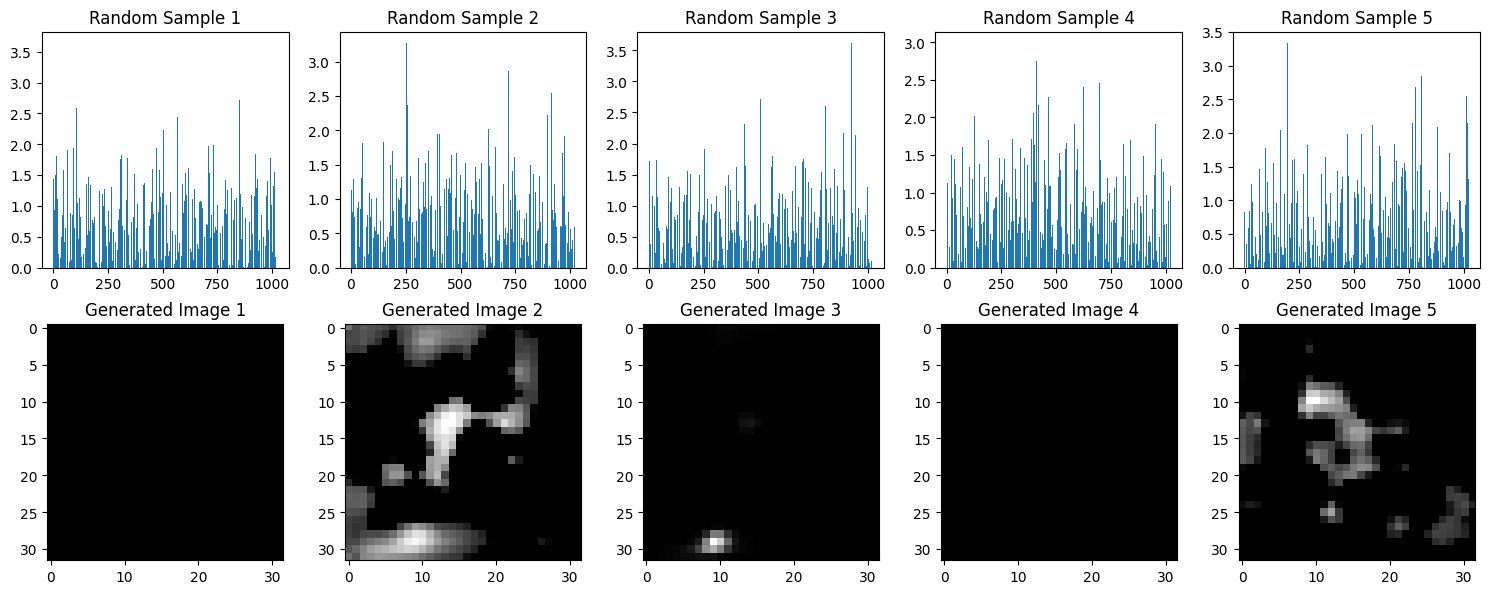

In [24]:
plot_generated_images(latent_distr_size=1024)